## Project: Finding Donors for _CharityML_

In this project, we will employ several __supervised algorithms__ to accurately model individuals' income using data collected from the 1994 U.S.Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

Our goal with this implementation is to construct a model that accurately predicts wheter an individual makes more than \$50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The article by Ron Kohavi can be found [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

### Exploring the Data

We start by loading necessary Python libraries and the census data. As we can note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py 
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration

A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than $50,000. In the code cell below, we will compute the following:

- The total number of records, `'n_records'`
- The number of individuals making more than $50,000 annually, `'n_greater_50k'`.

- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than $50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {0: .2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000:  24.78%


** Feature set Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Preparing the Data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as __preprocessing__. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

#### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: `'capital-gain'` and `'capital-loss'`.

The code cell below plots a histogram of these two features. We can note the range of the values present and how they are distributed.

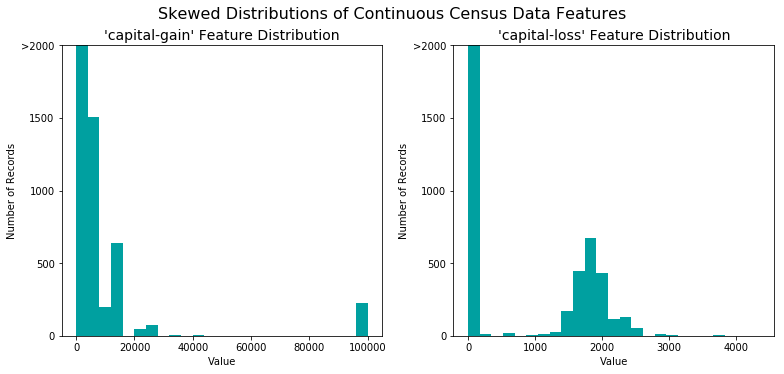

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a __logarithmic transformation__ on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

The code cell below performs a transformation on the data and visualize the results. Again, we can note the range of values and how they are distributed.

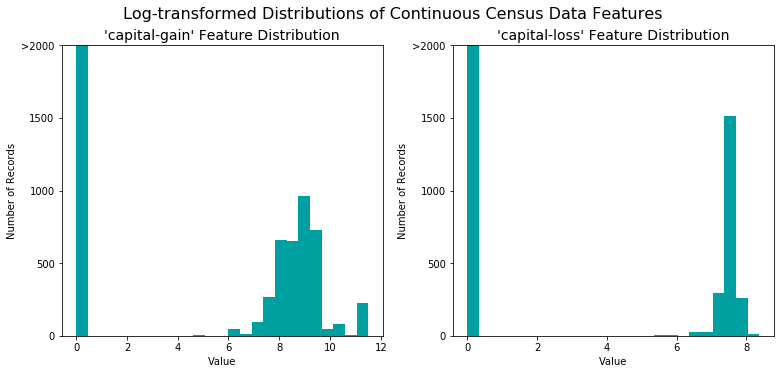

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of __scaling on numerical features__. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. We can note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [5]:
# Import sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of our choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, for example, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would that model's accuracy and F-score be on this dataset? We will use the code cell below and assign our results to `'accuracy'` and `'fscore'` to be used later.

** N.B: ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

** Remark: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. 
Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# We calculate accuracy, precision and recall
accuracy = n_greater_50k / n_records
recall = n_greater_50k/ n_greater_50k
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
b = 0.5
fscore = (1 + (b*b)) * ((precision * recall)/(((b*b) * precision)+ recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application
We start by listing three of the supervised learning models above that are appropriate for this problem that we will test on the census data. For each model chosen:

- We will describe one real-world application in industry where the model can be applied. And anwer the following questions:
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answers: **

* __Gaussian Naive Bayes (GaussianNB)__  In the real-world, Naïve Bayes classifiers are famously used for document classification and spam filtering (http://scikit-learn.org/stable/modules/naive_bayes.html).

`Pros`: Computationally fast, Simple to implement, works well with high dimensions

`Cons`: Relies on independence assumption and will perform badly if this assumption is not met.

I choose this model because Naïve Bayes classifiers can be extremely fast since each distribution can be independently estimated as a one-dimensional distribution. Thus, in terms of training time we won’t be penalized. Also our data has 5 features that are continuous.


* __Ensemble Methods (AdaBoost)__: AdaBoost algorithm can be used
for face and body parts recognition (https://www.uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf). 

`Pros`: AdaBoost is fast and simple to implement (few parameters to tune); no prior knowledge needed about weak learner. 

`Cons`: On one hand, weak classifiers too complex leads to overfitting, on the other hand weak classifiers too weak can lead to low margins, and can also lead to overfitting.

I choose this model because it has few parameters to tweak and it has the `feature_importances_` option that will help us to see what feature contribute the most in our prediction.


* __Support Vector Machines__ can be used to recognize hand-written characters (https://en.wikipedia.org/wiki/Support_vector_machine).

The Pros and Cons down here are from https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons 

`Pros:` Performs well with non-linear boundary depending on the kernel used, and handle high dimensional data well.

`Cons:` SVMs are less effective on noisier datasets with overlapping classes. The training time can be high when we have a large dataset.

For our data, I picked this model because of its parameters, especially the choice among kernels. Since we want to be accurate with our prediction, this model is also great in terms of accuracy.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    # using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end -  start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta= 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta= 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will need to implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model we use, if provided.
  - **Note:** We use the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on an algorithms, the following implementation may take some time to run!

/Users/christelilaka/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


/Users/christelilaka/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


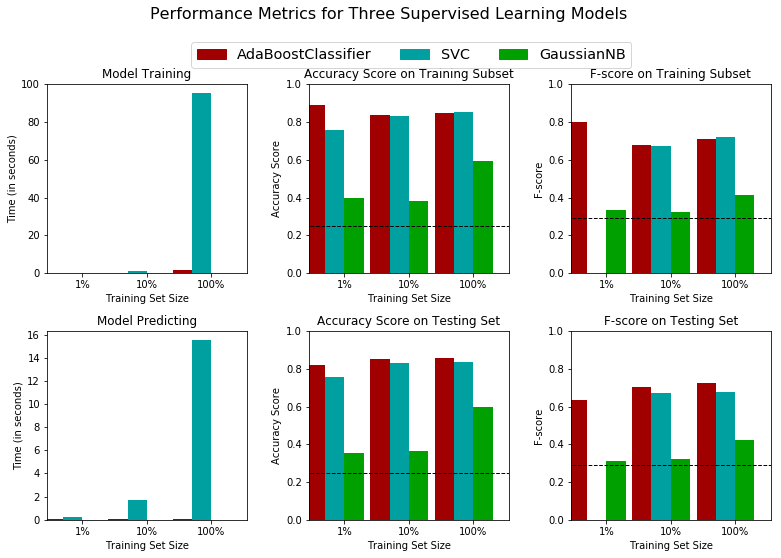

In [11]:
# Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = AdaBoostClassifier(random_state = 22)
clf_B = SVC(random_state = 12)
clf_C = GaussianNB() 

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(X_train.shape[0] * 1)
samples_10 = int(X_train.shape[0] * 0.1)
samples_1 = int(X_train.shape[0] * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use our data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

#### Choosing the Best Model

Based on the evaluation that we performed earlier, we could explain to *CharityML* which of the three models we believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 
 
We look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used; then we could answer the following question : _Which model has the highest score?_

**Answer: **

The best model here is __AdaBoost__ because of its F-score. This score tells us that AdaBoost is the model that has high precision than SVC and GaussianNB models before tuning of all models. In other words, since we want to be precise on our prediction, we did use a F-score with beta =0.5 and when we look at the graph of F-score on Testing Set when the training set size is 100%, we can see that the best model is AdaBoost. Another reason to choose this model is that it outperforms the second possible best model or SVC on the training time. This means that AdaBoost is faster than SVC in our case and this is prety good because if we have to train our model with the whole dataset, we know that we will not be penalize in terms of computer memories as if we did it with an SVC algorithm.

Finally, I think this algorithm suit our data because of the nature of ensemble methods models. With AdaBoost each “weak learner” solve a subset of the problem and at the end the algorithm combine all the solution to have a “strong learner” that will classifies well the unseen test sample.

### Describing the Model in Layman's Terms

AdaBoost is an ensemble classifier. This means that AdaBoost combines multiple “weak classifiers” into a single “strong classifier”. A weak classifier is simply a classifier that performs poorly, but performs better than random guessing. However, when combined, all these “weak classifiers” help us better classify our data. The algorithm works as follow: the first “weak classifier” split a subset of the data into two categories and the algorithm remember the result; then the second “weak learner” try to correct the misclassified data from the first one by using also a subset of the data. This process is repeated for the 3rd, the 4th, and so on learner. At the end, the algorithm combine all the results of the “weak classifiers” and classify the whole data.

http://mccormickml.com/2013/12/13/adaboost-tutorial/

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. In the code cell below, we will implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state we set before.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of our learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [12]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# Initialize the classifier
clf = AdaBoostClassifier(random_state = 12)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.5, 1.0, 1.5]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448


### Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmarks found earlier?

###### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |0.8576             |  0.8676         |
| F-score        |0.7246             |  0.7448         |


The optimized model performs slightly better than the unoptimized one in both category accuracy and F-score. With this model, we have an accuracy of 86.76% and this is good because our F-score is close to one or 0.7448; however, with this F-score we can see that we can still improve our model.

The optimized model is by far better than the naïve predictor benchmarks because the latest had an accuracy of 24.78% and its F-score was close to zero or 0.2917.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell we will fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we implement the following:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

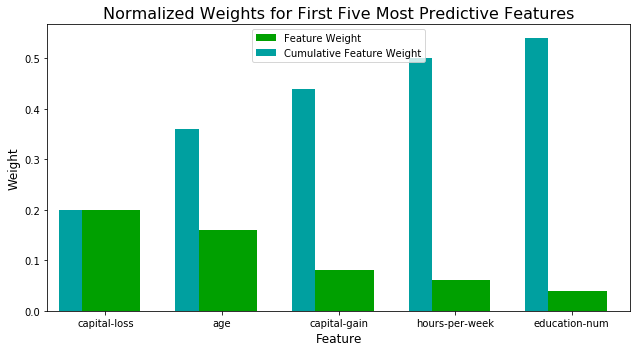

In [13]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Here, `feature_importances_` parameter shows us the top 5 most important features for prediction and ranks them as well.

One might be surprise by the choice of `capital-loss` and `capital-gain`, but when we think about it, the features selection and ranking by algorithm makes more sense because it's more possible to make 50K or more when a person has a high capital_gain and with no loss than the inverse.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8676
F-score on testing data: 0.7448

Final Model trained on reduced data
------
Accuracy on testing data: 0.8433
F-score on testing data: 0.7053


#### Question on Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would we consider using the reduced data as our training set?

**Answer:**

The final F-score and accuracy score dropped a little bit when the model is trained with five features. I think this is because the model does not generalize well the data to predict the income level. But, this could be handy if the training time was a factor even though our model will be penalized in term of accuracy because we will have more classification errors.